### Cargar archivos adicionales de la nube

In [ ]:
import os
if os.path.exists('Imagenes'):   
    print ('La carpeta ya existe')
else:
    os.system('wget -nc https://www.dropbox.com/s/i80af08mp0y5ux5/Imagenes.zip?dl=1')
    os.system('unzip Imagenes.zip?dl=1')
    os.system('rm -r Imagenes.zip?dl=1')
    print('ImAgenes descargadas')

Object Detection using Haar feature-based cascade classifiers is an effective method proposed by Paul Viola and Michael Jones in the 2001 paper, "Rapid Object Detection using a Boosted Cascade of Simple Features". 

It is a machine learning based approach in which a cascade function is trained from a lot of positive and negative images. 

 - It is then used to detect objects in other images.

Here we will work with face detection. 

- Initially, the algorithm needs a lot of positive images (images of faces) and negative images (images without faces) to train the classifier. 

- Then we need to extract features from it. 

- For this, Haar features are used. 


They are just like our convolutional kernel. Each feature is a single value obtained by subtracting the sum of pixels under the white rectangle from the sum of pixels under the black rectangle.

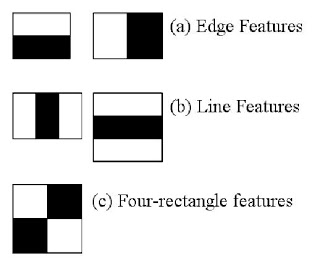

Now all possible sizes and locations of each kernel are used to calculate plenty of features. 

For each feature calculation, we need to find the sum of the pixels under the white and black rectangles. 

To solve this, they introduced the integral images. It simplifies calculation of the sum of the pixels, how large may be the number of pixels, to an operation involving just four pixels ( https://datasciencechalktalk.com/2019/07/16/haar-cascade-integral-image/ ).

But among all these features most of them are irrelevant. 

For example, consider the image below. Top row shows two good features. 

The first feature selected seems to focus on the property that the region of the eyes is often darker than the region of the nose and cheeks. 

The second feature selected relies on the property that the eyes are darker than the bridge of the nose. 

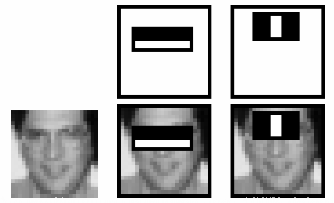

But the same windows applying on cheeks or any other place is irrelevant. 

So how do we select the best features out of 160000+ features? It is achieved by Adaboost.

For this, we apply each and every feature on all the training images. 

For each feature, it finds the best threshold which will classify the faces to positive and negative. 

- But obviously, there will be errors or misclassifications. 

We select the features with minimum error rate, which means they are the features that best classifies the face and non-face images.

Final classifier is a weighted sum of these weak classifiers. 

- It is called weak because it alone can't classify the image, but together with others forms a strong classifier. 

The paper says even 200 features provide detection with 95% accuracy. 

Their final setup had around 6000 features(Imagine a reduction from 160000+ features to 6000 features. That is a big gain).


In an image, most of the image region is non-face region. 

So it is a better idea to have a simple method to check if a window is not a face region. 

 If it is not, discard it in a single shot. Don't process it again. 
 
Instead focus on region where there can be a face. This way, we can find more time to check a possible face region.

For this they introduced the concept of Cascade of Classifiers. 

- Instead of applying all the 6000 features on a window, group the features into different stages of classifiers and apply one-by-one. (Normally first few stages will contain very less number of features). If a window fails the first stage, discard it. We don't consider remaining features on it. If it passes, apply the second stage of features and continue the process. 

The window which passes all stages is a face region.

Authors' detector had 6000+ features with 38 stages with 1, 10, 25, 25 and 50 features in first five stages. 

According to authors, on an average, 10 features out of 6000+ are evaluated per sub-window.

So this is a simple intuitive explanation of how Viola-Jones face detection works. Read paper for more details.

### Cargar librerías

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:
#Cargar los clasificadores
face_cascade = cv2.CascadeClassifier("C:/Users/SANTIAGO/PDI Procesamiento Digital de Imagenes/Unidad 3 - OpenCV/Datasets/1/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("C:/Users/SANTIAGO/PDI Procesamiento Digital de Imagenes/Unidad 3 - OpenCV/Datasets/1/haarcascade_eye.xml")

(-0.5, 735.5, 980.5, -0.5)

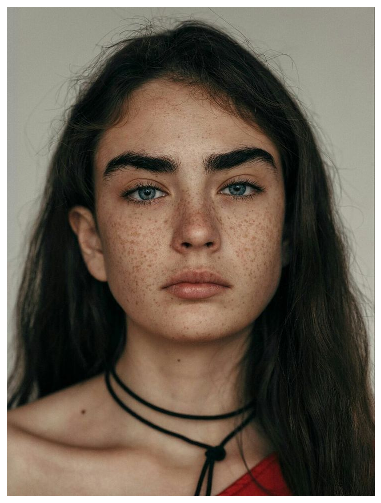

In [12]:
#Cargar imagen
img = cv2.imread("C:/Users/SANTIAGO/PDI Procesamiento Digital de Imagenes/Unidad 3 - OpenCV/Datasets/1/rostro.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,9))
plt.imshow(img)
plt.axis('off')

```
NombreV=NombreC.detectMultiScale(
        ImaGris,
        scaleFactor = 1.2,
        minNeighbors = 5,
        minSize= (30,30),
        maxSize= (200,200),
        flags = cv2.CASCADE_SCALE_IMAGE)
```
NombreV: la funcion retorna un vector de los rostros y las coordenadas $x$ y $y$ de la esquina superior izquierda del rectangulo que abarca el rostro y el ancho y alto ($w$, $h$) del mismo.

ImaGris: Imagene en escala de grises.

scaleFactor:   Parámetro que especifica cuánto se reduce el tamaño de la imagen en cada escala de imagen. La imagen es escalada siguiendo una secuencia piramidal y en ella se aplican los diferentes clasificadores. Entre más pequeño es el factor, más detecciones puede realizar pero la ejecución del algoritmo requiere más recursos de máquina.

minNeighbors:  Parámetro que especifica cuántos vecinos debe tener cada rectángulo candidato para conservarlo. Este parámetro afectará la calidad de las caras detectadas. Mayor valor resulta en menos detecciones pero con mayor calidad. 3~6 es un buen valor para ello.

minSize:       Tamaño mínimo del objeto.

maxSize:       Tamaño máximo del objeto.

flags:         Parámetro con el mismo significado para una cascada antigua que en la función cvHaarDetectObjects. No se utiliza para una nueva cascada.

In [13]:
#Cambio a escala de grises
gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#Detección del rostro (o rostros si hay mas de uno)
faces = face_cascade.detectMultiScale(gray, 1.35, 5)

In [14]:
#La primera dimensión determina el número de rostros encontrados
#La segunda son los 4 parámetros de rectangulo del rostro
np.shape(faces)

(1, 4)

### Detección de ojos
La detección de los ojos se realiza unicamente en la región del rostro, por lo tanto, se extrae la ROI correpondiente y se realiza el mismo proceso que en la detección de rostros pero en este caso se utiliza el clasificador de ojos.

In [15]:
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),2)
    
    #Extracción de la ROI
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    
    #Detección de ojos
    eyes = eye_cascade.detectMultiScale(roi_gray, 1.35, 6)
    
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(40,55,200),2)

(-0.5, 735.5, 980.5, -0.5)

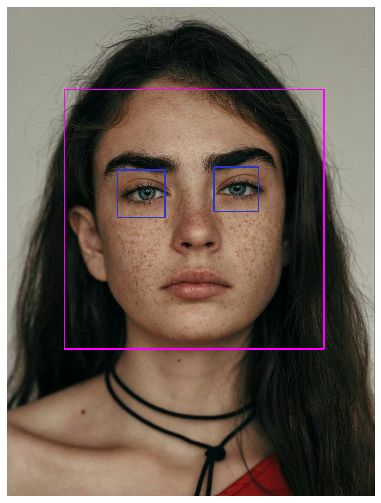

In [16]:
plt.figure(figsize=(15,9))
plt.imshow(img)
plt.axis('off')